In [40]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
from ast import literal_eval
from fitter import Fitter
from scipy.stats import expon

In [ ]:
# get ecDNA intervals from ccle dataset

In [7]:
ccle = pd.read_csv("/Users/michael/Downloads/amplicon_repo_datasets/ccle_aggregated_results.csv")

In [8]:
ccle["Location"] = ccle.apply(lambda x : x["Location"].replace("\"", ""), axis = 1)

In [9]:
ccle_ecdna = ccle[ccle["Classification"] == "ecDNA"]

In [10]:
locations = ccle_ecdna['Location'].to_list()

In [11]:
locations

["['chr6:20350615-22839372']",
 "['chr3:9099507-9519221', 'chr3:9521655-10184493', 'chr3:10187258-14005720']",
 "['chr8:124484622-125582885', 'chr8:125588889-125953950']",
 "['chr8:52712046-56014576', 'chr8:65533018-65573949', 'chr8:71974787-71975210']",
 "['chr8:33167666-33301262', 'chr8:33302858-34254640', 'chr20:34283685-34285398', 'chr20:34299250-34611096']",
 "['chr3:61013233-61105860']",
 "['chr3:195779887-195783346', 'chr3:195783876-195788432', 'chr3:196035694-196047057', 'chr3:196048094-196050519', 'chr3:196051160-196090764', 'chr22:22863501-22941860']",
 "['chr4:161967909-162770269']",
 "['chr20:537320-1408502', 'chr20:1410170-1580396', 'chr20:1613533-1804925']",
 "['chr3:37937674-38298744']",
 "['chr8:71754758-71754831', 'chr8:71755523-72875541', 'chr8:72881587-74450636', 'chr8:74454727-74804209', 'chr8:75084883-75089985', 'chr8:75090041-80890260', 'chr8:80933178-80939945', 'chr8:86806127-87315900', 'chr8:87545736-87559512', 'chr8:87631519-88868891', 'chr8:89749344-90215126',

In [12]:
# function to extract lengths from input list
def process_intervals(input_list):
    interval_lengths = []
    feature_lengths = []
    intervals_are_multichr = []
    
    for feature in input_list:
        # convert to list
        intervals = literal_eval(feature)
        nonempty = len(intervals) > 0 and intervals != ['']
        # compute length of each interval
        if nonempty:
            toSum = []
            chr_nums = []
            for interval in intervals:
                # extract interval info
                pattern = r"chr(\d+|X):(\d+)-(\d+)"
                match = re.search(pattern, interval)
                if match:
                    chr_num, start, end = match.groups()
                else:
                    print(f"No match found for {interval}")
                chr_nums.append(chr_num)
                toSum.append(int(end) - int(start))
                # add interval to individual list
                interval_lengths.append(int(end) - int(start))
            # add summed intervals to feature list
            feature_lengths.append(sum(toSum))
            # check if multichromosomal
            multi_bool = 0
            for num in chr_nums:
                if not num == chr_nums[0]:
                    multi_bool = 1
                    break
            intervals_are_multichr.append(multi_bool)
            
    return interval_lengths, feature_lengths, intervals_are_multichr

In [13]:
interval_lengths, feature_lengths, intervals_are_multichr = process_intervals(locations)

In [14]:
# multichromosomal fraction
sum(intervals_are_multichr), len(feature_lengths), sum(intervals_are_multichr) / len(feature_lengths)

(51, 361, 0.14127423822714683)

In [15]:
len(interval_lengths), len(feature_lengths), len(locations)

(1144, 361, 361)

In [ ]:
# convert to df

In [19]:
intervals_df = pd.DataFrame(interval_lengths, columns=['Numbers'])

In [63]:
intervals_single = [i for i,m in zip(interval_lengths, intervals_are_multichr) if not m]

intervals_single_df = pd.DataFrame(intervals_single)

intervals_single_df.describe()

,0
count,3.100000e+02
mean,6.789435e+05
std,1.055895e+06
min,6.300000e+01
25%,3.113175e+04
50%,2.654765e+05
75%,9.307432e+05
max,6.821360e+06


In [20]:
intervals_df.describe()

,Numbers
count,1.144000e+03
mean,5.370609e+05
std,8.904239e+05
min,2.000000e+00
25%,2.426925e+04
50%,1.726305e+05
75%,6.687798e+05
max,7.227786e+06


In [21]:
Q1 = intervals_df['Numbers'].quantile(0.25)  # 25th percentile
Q3 = intervals_df['Numbers'].quantile(0.75)  # 75th percentile
IQR = Q3 - Q1
lower_threshold = Q1 - 1.5 * IQR
upper_threshold = Q3 + 1.5 * IQR

In [24]:
lower_threshold, upper_threshold

(-942496.5, 1635545.5)

In [61]:
intervals_outliers = intervals_df[intervals_df['Numbers'] > upper_threshold]
intervals_outliers.describe()

,Numbers
count,1.000000e+02
mean,2.805098e+06
std,1.321213e+06
min,1.635751e+06
25%,1.944802e+06
50%,2.367775e+06
75%,2.969322e+06
max,7.227786e+06


In [43]:
intervals_no_outliers = intervals_df[intervals_df['Numbers'] < upper_threshold]

In [60]:
intervals_no_outliers.describe()

,Numbers
count,1.044000e+03
mean,3.198160e+05
std,4.034213e+05
min,2.000000e+00
25%,1.730825e+04
50%,1.381740e+05
75%,4.684545e+05
max,1.632192e+06


In [ ]:
# using fitter to test different distributions

2025-01-25 14:59:50.462 | WARNING  | fitter.fitter:_fit_single_distribution:337 - SKIPPED _fit distribution (taking more than 30 seconds)
2025-01-25 14:59:50.487 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted anglit distribution with error=0.0)
2025-01-25 14:59:50.515 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted arcsine distribution with error=0.0)
2025-01-25 14:59:50.522 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted alpha distribution with error=0.0)
2025-01-25 14:59:50.533 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted argus distribution with error=0.0)
2025-01-25 14:59:50.539 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted cauchy distribution with error=0.0)
2025-01-25 14:59:50.567 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted cosine distribution with error=0.0)
2025-01-25 14:59:50.593 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted chi2 distribution with e

2025-01-25 14:59:52.252 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted kappa4 distribution with error=0.0)
2025-01-25 14:59:52.284 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted ksone distribution with error=0.0)
2025-01-25 14:59:52.292 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted pareto distribution with error=0.0)
2025-01-25 14:59:52.461 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted pearson3 distribution with error=0.0)
/Users/michael/anaconda3/lib/python3.10/site-packages/scipy/stats/_continuous_distns.py:3485: IntegrationWarning: The algorithm does not converge.  Roundoff error is detected
  in the extrapolation table.  It is assumed that the requested tolerance
  cannot be achieved, and that the returned result (if full_output = 1) is 
  the best which can be obtained.
  t1 = integrate.quad(llc, -np.inf, x)[0]
2025-01-25 14:59:52.484 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted powerlaw 

             sumsquare_error          aic          bic  kl_div  ks_statistic  \
fatiguelife     1.216429e-11  3117.375166  3132.227610     inf      0.229048   
mielke          1.413125e-11  3186.473958  3206.277217     inf      0.185052   
burr12          1.490125e-11  3235.832191  3255.635450     inf      0.240245   
johnsonsu       1.654849e-11  3132.899625  3152.702884     inf      0.137260   
nct             1.771640e-11  3240.865437  3260.668696     inf      0.221665   

                ks_pvalue  
fatiguelife  1.257646e-48  
mielke       9.119326e-32  
burr12       1.622400e-53  
johnsonsu    1.282152e-17  
nct          1.546718e-45  


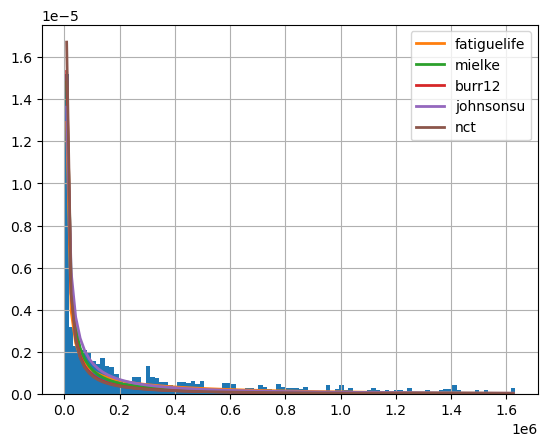

/Users/michael/anaconda3/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


In [33]:
f = Fitter(intervals_no_outliers)
f.fit()
print(f.summary())

In [34]:
f.get_best()

{'fatiguelife': {'c': 4.087390011411001,
  'loc': -287.3206721470797,
  'scale': 26297.62638444689}}

       sumsquare_error          aic          bic  kl_div  ks_statistic  \
gamma     5.020181e-11  3215.821997  3230.674441     inf      0.172207   

          ks_pvalue  
gamma  1.530280e-27  


2025-01-25 15:10:36.499 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted gamma distribution with error=0.0)


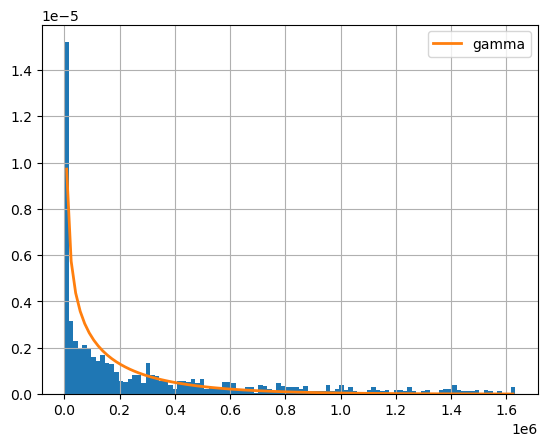

In [39]:
f = Fitter(intervals_no_outliers, distributions=['gamma'])
f.fit()
print(f.summary())

In [36]:
f.get_best()

{'gamma': {'a': 0.569504897386201,
  'loc': 1.9999999999999996,
  'scale': 304238.4694626314}}

       sumsquare_error          aic          bic  kl_div  ks_statistic  \
expon     1.582722e-10  3049.455025  3059.356655     inf      0.204764   

          ks_pvalue  
expon  7.344356e-39  


2025-01-25 15:08:42.487 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted expon distribution with error=0.0)


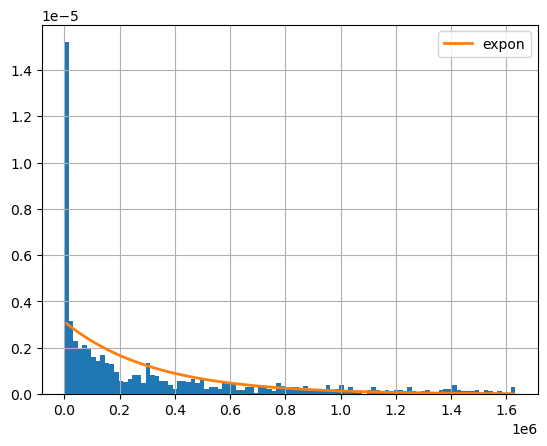

In [37]:
f = Fitter(intervals_no_outliers, distributions=['expon'])
f.fit()
print(f.summary())

In [38]:
f.get_best()

{'expon': {'loc': 2.0, 'scale': 319813.96455938695}}

In [41]:
# using scipy to fit the exponential dist

In [48]:
loc, scale = expon.fit(intervals_no_outliers)

lambda_param = 1/scale

print(f"Fitted lambda: {lambda_param}, loc: {loc}, scale: {scale}")

test_value = 

cdf = expon.cdf(test_value, loc=loc, scale=scale)

1-cdf

Fitted lambda: 3.1268178091526328e-06, loc: 2.0, scale: 319813.96455938695


/Users/michael/anaconda3/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3430: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)


array([0.36787944])

In [ ]:
# histogram plots for experimental interval dists

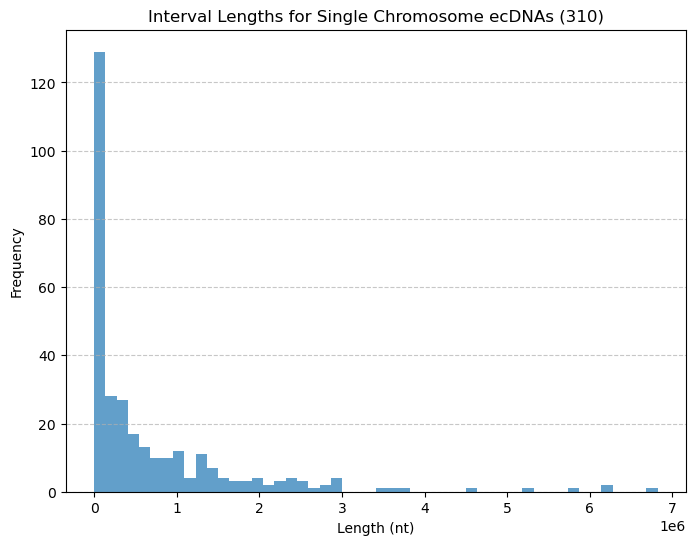

In [58]:
plt.figure(figsize=(8, 6))
plt.hist(intervals_single, bins=50, alpha=0.7)
plt.title("Interval Lengths for Single Chromosome ecDNAs (310)")
plt.xlabel("Length (nt)")
plt.ylabel("Frequency")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

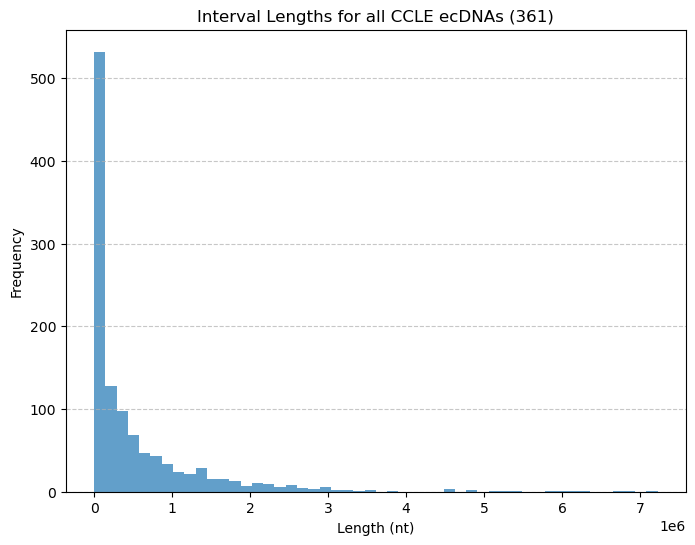

In [59]:
plt.figure(figsize=(8, 6))
plt.hist(interval_lengths, bins=50, alpha=0.7)
plt.title("Interval Lengths for all CCLE ecDNAs (361)")
plt.xlabel("Length (nt)")
plt.ylabel("Frequency")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

In [31]:
cutoff = 25000
intervals_cutoff = [i for i in interval_lengths if i < cutoff]

In [ ]:
plt.figure(figsize=(8, 6))
plt.hist(intervals_cutoff, bins=50, alpha=0.7)
plt.title("Interval Lengths < 100000")
plt.xlabel("Length (nt)")
plt.ylabel("Frequency")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

In [ ]:
plt.figure(figsize=(8, 6))
plt.hist(feature_lengths, bins=50, alpha=0.7)
plt.title("Interval Lengths Summed Per Feature")
plt.xlabel("Length (nt)")
plt.ylabel("Frequency")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

In [ ]:
# function to save list to text file
def save_list_to_txt(numbers, filename):
    with open(filename, 'w') as f:
        for number in numbers:
            f.write(f"{number}\n")

In [ ]:
save_list_to_txt(lengths1, "ccle_interval_lengths.txt")
save_list_to_txt(lengths2, "ccle_interval_lengths_summed_by_feature.txt")